# **Task \#4 B**: Machine Learning MC886/MO444
##**Natural Language Processing (NLP)**##

In [ ]:
print('Daniel Gardin Gratti ' + '214729')
print('Beatriz Cardoso Nascimento' + ' 247403')

Daniel Gardin Gratti 214729
Beatriz Cardoso Nascimento 247403


## Objective:

There are two main objectives of this notebook: you can either fine-tunning a BERT model to sentiment analysis or fine-tunning a T5 model to perform translation English to Portuguese.

**You can choose which task to perform. The BERT activity is relatively easy and should take less time compared to the T5 task. However, fine-tuning these models require time. Therefore, it is recommended to test the models on a small dataset (such as one batch), to ensure the functions are working correctly. Once confirmed, you can proceed to train the models on the entire dataset.**

**If you complete both tasks, you will earn extra points.**
**Obs: In this work, you can use scikit-learn, PyTorch and HuggingFace API.**

## **Sentiment Analisys**

Sentiment analysis is a task in natural language processing that involves determining the sentiment expressed in a given text, classifying it as positive, negative, or neutral. It helps analyze people's opinions and emotions from text data, enabling businesses to understand customer feedback, monitor brand reputation, and make informed decisions.

In this notebook, we will use the IMDB Dataset, which is widely used in the field of natural language processing and sentiment analysis. It comprises a large collection of movie reviews from the IMDB website, with each review labeled as either positive or negative based on the sentiment expressed in the text.

![bert_model](https://drive.google.com/uc?export=view&id=1rWKk7K5-0MX8EkjPeRZTaG7byFQuD6Cx)

BERT (Bidirectional Encoder Representations from Transformers) is a state-of-the-art deep learning model for natural language processing (NLP). It is based on the Transformer architecture and is pre-trained on a large corpus of text data. BERT is designed to understand the context and meaning of words in a sentence by considering both the left and right context, enabling it to capture intricate language patterns. It has achieved remarkable results across various NLP tasks, including text classification, named entity recognition, question answering, and has significantly advanced the field of NLP.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Download Dependencies

In [ ]:
%%time
!wget -nc -q http://files.fast.ai/data/aclImdb.tgz
!tar -xzf aclImdb.tgz
!pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 85.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.7 MB/s eta 0:00:00
CPU times: user 185 ms, sys: 15.6 ms, total: 201 ms
Wall time: 31.1 s


In [ ]:
import os
import gc
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import matplotlib.pyplot as plt


from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset

from transformers import BertTokenizerFast, BertModel, get_linear_schedule_with_warmup

### Parameters

In [ ]:
params = {
    'bert_version': 'bert-base-uncased',
    # There are multiple versions of BERT available at the following links:
    # https://huggingface.co/google/bert_uncased_L-12_H-768_A-12
    # https://huggingface.co/bert-base-uncased
    # You can explore these links to access different versions of BERT.

    'batch_size': 16,
    'learning_rate': 1e-4, # Choose a learning rate between 1e-4 and 1e-5
    'max_length': 300,     # The maximum length of the sentence (can be adjusted)
    'epochs': 10,        # Choose a value between 1 and 5 (or alternatively, use early stopping)
}

In [ ]:
# Important: Fix seeds so we can replicate results
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

Device: cuda:0


### Load data

Here we are loading the data. For training, we will use 20k samples, 5k samples for validation, and 25k samples for testing.

In [ ]:
max_valid = 5000

def load_texts(folder):
    texts = []
    for path in os.listdir(folder):
        with open(os.path.join(folder, path)) as f:
            texts.append(f.read())
    return texts

x_train_pos = load_texts('aclImdb/train/pos')
x_train_neg = load_texts('aclImdb/train/neg')
x_test_pos  = load_texts('aclImdb/test/pos')
x_test_neg  = load_texts('aclImdb/test/neg')

x_train = x_train_pos + x_train_neg
x_test  = x_test_pos + x_test_neg
y_train = [True] * len(x_train_pos) + [False] * len(x_train_neg)
y_test  = [True] * len(x_test_pos)  + [False] * len(x_test_neg)

c = list(zip(x_train, y_train))
random.shuffle(c)
x_train, y_train = zip(*c)

x_valid = x_train[-max_valid:]
y_valid = y_train[-max_valid:]
x_train = x_train[:-max_valid]
y_train = y_train[:-max_valid]

print('\nFirst three train samples:')
for i, (source, target) in enumerate(zip(x_train[:3], y_train[:3])):
  print(f"{i}: Input: {source}\n   Target: {'positive' if target else 'negative'}\n")

print('-'*200)
print('\nFirst three valid samples:')
for i, (source, target) in enumerate(zip(x_valid[:3], y_valid[:3])):
  print(f"{i}: Input: {source}\n   Target: {'positive' if target else 'negative'}\n")

print('-'*200)
print(f'Train size: {len(x_train)}')
print(f'Valid size: {len(x_valid)}')
print(f'Valid size: {len(x_test)}')


First three train samples:
0: Input: There have been very few films I have not been able to sit through. I made it through Battle Field Earth no problem. But this, This is one of the single worst films EVER to be made. I understand Whoopi Goldberg tried to get of acting in it. I do not blame her. I would feel ashamed to have this on a resume. I belive it is a rare occasion when almost every gag in a film falls flat on it's face. Well it happens here. Not to mention the SFX, look for the dino with the control cables hanging out of it rear end!!!!!! Halfway through the film I was still looking for a plot. I never found one. Save yourself the trouble of renting this and save 90 minutes of your life.
   Target: negative

1: Input: I have seen Maslin Beach a couple of times - both on free to air TV in Brisbane. I won't go into whether it is good, bad or otherwise as others have well and truly covered this.<br /><br />I will say that it is so Australian. Only in Australia can we have a film

### Tokenizer

To use text as input for a deep learning model, we first need to tokenize each sentence based on a set of rules. After tokenization, each token is assigned a correlated index, creating a feature vector. This vector is then utilized by the model to train and update the weights. Here is an example demonstrating how the BERT tokenizer works:

![bert_tokenizer](https://drive.google.com/uc?export=view&id=11LioDFis0JE3ghr672PEIeaAxZO42gUL)

Initially, the input sentence is divided into tokens predetermined by the BERT tokenizer. Next, the BertTokenizer introduces two special tokens: CLS and SEP. CLS represents sentence start for tasks like classification, while SEP indicates sentence separation for boundary detection within a document. Additionally, to ensure sentences are of equal length, the tokenizer employ the PAD token for each input.

Finally, each token is converted into a predetermined index for BERT input. This indexing enables the Bert model to train and update its weights effectively.

In [ ]:
class IMDBDataset(Dataset):
    def __init__(self, data, labels):
        super().__init__()
        self.data   = data
        self.labels = torch.Tensor(labels).long()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        item = {key: value[index] for key, value in self.data.items()}
        item['labels'] = self.labels[index]
        return item

In [ ]:
%%time
tokenizer = BertTokenizerFast.from_pretrained(params['bert_version'], disable_tqdm=False)

## TOKENIZE
train_encodings = tokenizer(list(x_train), truncation=True, padding=True, return_tensors='pt', max_length=params['max_length'])
valid_encodings = tokenizer(list(x_valid), truncation=True, padding=True, return_tensors='pt', max_length=params['max_length'])
test_encodings  = tokenizer(list(x_test),  truncation=True, padding=True, return_tensors='pt', max_length=params['max_length'])

## DATASET
train_dataset = IMDBDataset(data=train_encodings, labels=y_train)
valid_dataset = IMDBDataset(data=valid_encodings, labels=y_valid)
test_dataset  = IMDBDataset(data=test_encodings, labels=y_test)

## DATALOADER
train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True, num_workers=1)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=params['batch_size'], num_workers=1)
test_loader  = DataLoader(dataset=test_dataset, batch_size=params['batch_size'], num_workers=1)

CPU times: user 1min 13s, sys: 2.1 s, total: 1min 15s
Wall time: 1min


### Useful functions

**Note:** The following functions are provided as suggestions. You are free to modify and create your own functions, classes, or code. Feel free to customize!

**If the batch does not fit in memory, use gradient accumulation.**

**Hint 1:** Example of gradient accumalation in PyTorch: https://kozodoi.me/blog/20210219/gradient-accumulation.

**Hint 2:** If preferred, you can utilize the [Trainer](https://huggingface.co/docs/transformers/training) from Hugging Face for assistance.

In [ ]:
@torch.no_grad()
def evaluate(logit, target, threshold=0.5):
    pred = torch.where(logit.detach() > threshold, 1, 0)
    acc = (torch.count_nonzero(pred == target)/torch.numel(target)).item()

    return {'accuracy': acc}


def metrics2string(metrics):
    return '   '.join([f"{metric} {value : >2.2%}" for metric, value in metrics.items()])


def train(model, train_loader, valid_loader, optimizer, criterion, epochs, patience=None):
    device = next(model.parameters()).device

    best_score = 0
    counter = 0

    history = []
    val_history = []

    n_batches = len(train_loader)
    for epoch in range(epochs):
        model.train()

        # Training loop
        epoch_history = []
        for n_batch, data in enumerate(train_loader):
            gc.collect()
            torch.cuda.empty_cache()
            target  = data['labels'].float().to(device)[:, None]

            pred = model(data)

            loss = criterion(pred, target)
            metrics = evaluate(pred, target)

            loss.backward()

            if (n_batch + 1) % 1 == 0:
                optimizer.step()
                optimizer.zero_grad()

            print(f'\rEPOCH {epoch + (n_batch+1)/n_batches : >05.3f} |   loss: {loss.item() : >4.3f}   {metrics2string(metrics)}         ', end='')

            metrics['loss'] = loss.item()

            epoch_history.append(metrics)


        history.append(epoch_history)

        epoch_metric = {metric : np.mean([hist[metric] for hist in epoch_history]) for metric in metrics.keys()}
        epoch_loss   = epoch_metric.pop('loss')
        with torch.no_grad():
            model.eval()
            val_bucket = []
            val_losses = 0
            for data in valid_loader:
                target  = data['labels'].float().to(device)[:, None]

                pred = model(data)

                val_loss  = criterion(pred, target)
                val_losses += val_loss.item()

                metrics = evaluate(pred, target)
                val_bucket.append(metrics)

                print(f'\rEPOCH {epoch + (n_batch+1)/n_batches : >05.3f} |   loss: {epoch_loss : >4.3f}   {metrics2string(epoch_metric)}  | Validation:  loss: {val_loss : >05.3f}   {metrics2string(metrics)}    ', end='')

        val_metric = {metric : np.mean([hist[metric] for hist in val_bucket]) for metric in metrics.keys()}
        val_losses /= len(valid_loader)

        print(f'\rEPOCH {epoch + (n_batch+1)/n_batches : >05.3f} |   loss: {epoch_loss : >4.3f}   {metrics2string(epoch_metric)}  | Validation:  loss: {val_losses : >05.3f}   {metrics2string(val_metric)}     ', end='')
        print()

        val_metric['loss'] = val_losses

        val_history.append(val_metric)

        # Early stopping mechanism if patience is set

        if patience is None: continue

        if val_metric['accuracy'] < best_score + 1e-4:
            counter += 1

            if counter >= patience:
                print(f"Training Early Stopped after {epoch} epochs")
                break

        else:
            counter = 0
            best_score = val_metric['accuracy']

            torch.save(model.state_dict(), 'drive/MyDrive/best_weights.pth')

    return history, val_history

### Train the BERT model

**Note:** The following functions are provided as suggestions. You are free to modify and create your own functions, classes, or code. Feel free to customize!

**Hint 1:** See the [BertForSequenceClassification](https://huggingface.co/docs/transformers/v4.30.0/en/model_doc/bert#transformers.BertForSequenceClassification) documentation for more information.

**Hint 2:** Instead of saving information by epoch, you can save it by step. A step corresponds to a single update of the model's weights based on a mini-batch of data, while an epoch represents a complete pass through the entire training dataset. The number of steps is determined by the batch size and the total number of training examples, whereas the number of epochs is a user-defined hyperparameter.

**Hint 3:** BERT adapts very well to classification problems, so in just 3 or 4 epochs, the results are already acceptable (**BERT Base**). If the results are still not good, check the learning rate.

**Hint 4:** Conduct small tests, such as using only one batch, to train and verify the functionality of the training and evaluation functions. After confirming their effectiveness, proceed to train the model with all the dataset.

In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(params['bert_version'])
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, 1)

    # Forward propagaion class
    def forward(self, data_dict):
        device = next(self.parameters()).device

        input_ids      = data_dict['input_ids'].to(device)
        attention_mask = data_dict['attention_mask'].to(device)

        _, pooled_output = self.bert(input_ids=input_ids,
                                     attention_mask=attention_mask, return_dict=False)

        #  Add a dropout layer
        output = self.drop(pooled_output)
        output = self.out(output)
        return F.sigmoid(output)


In [ ]:
model = SentimentClassifier()
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5) # https://pytorch.org/docs/stable/optim.html
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_dataset) * params['epochs']
) # https://pytorch.org/docs/stable/optim.html (not mandatory)

criterion = nn.BCELoss()

history, val_history = train(model, train_loader, valid_loader, optimizer, criterion, epochs=20, patience=1)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


EPOCH 1.000 |   loss: 0.269   accuracy 88.85%  | Validation:  loss: 0.224   accuracy 91.57%     
EPOCH 2.000 |   loss: 0.139   accuracy 94.99%  | Validation:  loss: 0.211   accuracy 92.13%     
EPOCH 3.000 |   loss: 0.074   accuracy 97.59%  | Validation:  loss: 0.285   accuracy 90.18%     
Training Early Stopped after 2 epochs


#### Plot the Train and Valid loss

In [ ]:
def plot_history(history, val_history,  metrics, model_name, smooth_window=1, alpha=0.4):
    fig, axs = plt.subplots(1, len(metrics), figsize=(len(metrics)*8, 5))

    fig.suptitle(model_name)


    for i, metric in enumerate(metrics):
        metric_hist = np.array([[epoch_hist[metric] for epoch_hist in epoch_history] for epoch_history in history]).flatten()
        epochs      = np.linspace(0, len(history), num=len(metric_hist), endpoint=False)

        # Plot metric per batch
        axs[i].plot(epochs, metric_hist, alpha=alpha, color='b')

        # Moving average
        metric_hist = np.convolve(np.pad(metric_hist, (smooth_window//2,smooth_window//2), mode='edge'), np.ones(smooth_window)/smooth_window, mode='valid')
        axs[i].plot(epochs, metric_hist, linewidth=3, label="Training", color='b')

        val_hist    = [epoch_hist[metric] for epoch_hist in val_history]

        axs[i].plot(range(1, len(val_history)+1), val_hist, linewidth=3, label="Validation", color='orange')

        axs[i].set_title(f"{metric} per batch/epoch")

        axs[i].legend()

    plt.show()

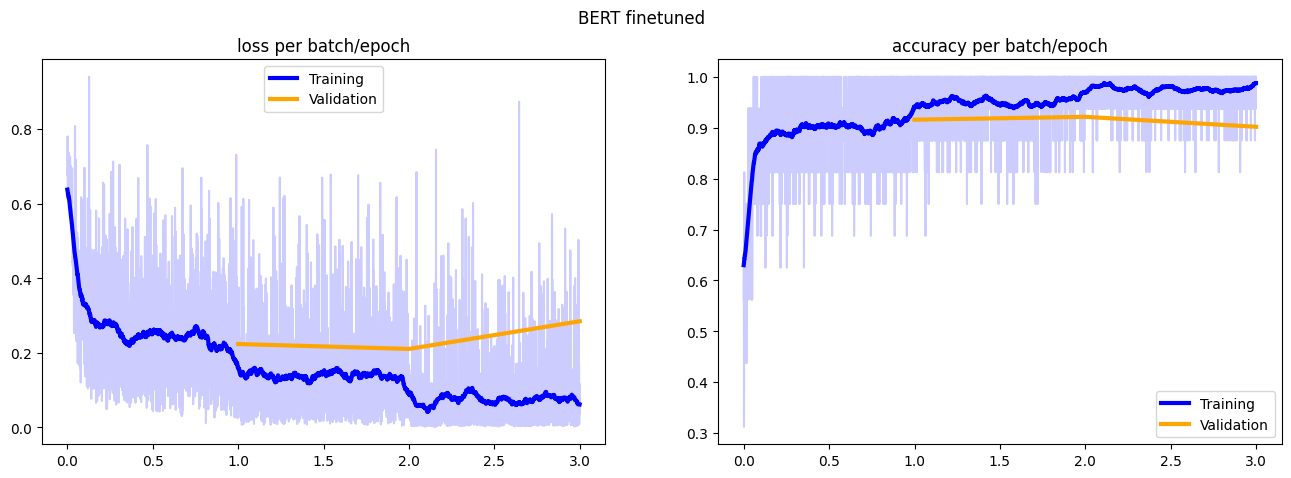

In [ ]:
plot_history(history, val_history, ['loss', 'accuracy'], model_name='BERT finetuned', smooth_window=101, alpha=0.2)

#### Evaluate in Test set

In [ ]:
weights = torch.load('drive/MyDrive/best_weights.pth', map_location=device)

model = SentimentClassifier().to(device)

model.load_state_dict(weights)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
criterion = nn.BCELoss()
with torch.no_grad():
    model.eval()
    loss = 0
    accuracy = 0
    for data in test_loader:
        target  = data['labels'].float().to(device)[:, None]

        pred = model(data)

        loss += criterion(pred, target).item()

        accuracy += evaluate(pred, target)['accuracy']

loss     = loss / len(test_loader)
accuracy = accuracy / len(test_loader)

print(f"The model has achieved an average loss of {loss:.3f} and a total accuracy of {accuracy:.2%} on test")

The model has achieved an average loss of 0.195 and a total accuracy of 92.37% on test


> What is your conclusions?

O modelo pré-treinado se adequou bem a tarefa de classificação, atingindo uma performance de 92% de acurácia no teste em apenas 2 épocas.

## **Translation task**

In Natural Language Processing (NLP), translation tasks involve converting text from one language to another. The Paracrawl dataset, a valuable resource for translation research, consists of parallel text data gathered from various websites, enabling the development and training of translation models.


The T5 (Text-To-Text Transfer Transformer) deep learning model is a versatile language model that excels at various NLP tasks. It operates on the principle of transforming input text into output text, making it a powerful tool for tasks such as text summarization, translation, question answering, and more. T5 achieves this flexibility by formulating different tasks as text generation problems, which enables it to be fine-tuned on specific tasks while leveraging its pre-trained knowledge.

![t5_model](https://drive.google.com/uc?export=view&id=1h8tTSHIwkTon5j2WkBZBr7j731mWtL4O)

**Original paper:** *RAFFEL, Colin et al. Exploring the limits of transfer learning with a unified text-to-text transformer. The Journal of Machine Learning Research, v. 21, n. 1, p. 5485-5551, 2020.*


In [ ]:
%%time
!pip install transformers sentencepiece torchmetrics -q

CPU times: user 35.3 ms, sys: 790 µs, total: 36.1 ms
Wall time: 4.22 s


### Imports and global variables

In [ ]:
import re
import copy
import gzip
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from transformers import T5Tokenizer, T5ForConditionalGeneration, get_linear_schedule_with_warmup

from typing import Dict
from typing import List
from typing import Tuple

In [ ]:
# Important: Fix seeds so we can replicate results
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

Device: cuda:0


### Parameters

In [ ]:
params = {
    'model_name': 'unicamp-dl/ptt5-small-portuguese-vocab',
    'batch_size': 64,
    'accumulate_grad_batches': 4,
    'source_max_length': 128, # Maximum number of tokens in the source sentence (you can select a different value)
    'target_max_length': 128, # Maximum number of tokens in the target sentence (you can select a different value)
    'learning_rate': 1e-3,
    'evaluate_interval': 500  # Intervals at which we will evaluate the model (in steps)
}

### Load data

Here we are loading the data. Notice that the label no longer consists of a class index, but instead, it comprises a complete sentence. In the modified Paracrawl dataset, the input sentence is in English, while the output sentence is in Portuguese.

For training, we will use 99k samples, 10k samples for validation, and 20k samples for testing.

**Note:** If you are experiencing issues with GPU allocation, you can reduce the number of training samples. Otherwise, it is advisable to utilize the entire dataset.

LINK TO THE [DATASET](https://drive.google.com/drive/folders/1tUwgkpcLXAsZizXUKfJeN5ZH75rEj3Js?usp=sharing)

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1vH1e4PmeRqx69sO-rSn0Fpooi_Ivw_f-' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1vH1e4PmeRqx69sO-rSn0Fpooi_Ivw_f-" -O paracrawl_en_pt_train.tsv.gz
!wget "https://docs.google.com/uc?export=download&id=1llIS8lNBEvvxScSxzLRPs-FpPybLbagj" -O paracrawl_en_pt_test.tsv.gz

--2023-07-06 03:11:32--  https://docs.google.com/uc?export=download&confirm=t&id=1vH1e4PmeRqx69sO-rSn0Fpooi_Ivw_f-
Resolving docs.google.com (docs.google.com)... 74.125.130.138, 74.125.130.139, 74.125.130.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.130.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-3s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/j0v0a6k9e2sgkpif47soho5g6qgmu8fq/1688613075000/01089768076506809926/*/1vH1e4PmeRqx69sO-rSn0Fpooi_Ivw_f-?e=download&uuid=b60b7c9e-026f-42c6-8085-d45d7859bdc0 [following]
--2023-07-06 03:11:32--  https://doc-04-3s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/j0v0a6k9e2sgkpif47soho5g6qgmu8fq/1688613075000/01089768076506809926/*/1vH1e4PmeRqx69sO-rSn0Fpooi_Ivw_f-?e=download&uuid=b60b7c9e-026f-42c6-8085-d45d7859bdc0
Resolving doc-04-3s-docs.googleusercontent.com (doc-04-3s-docs.googleusercontent.com)... 142.251.10.132, 

In [ ]:
def load_text_pairs(path):
    text_pairs = []
    for line in gzip.open(path, mode='rt'):
        text_pairs.append(line.strip().split('\t'))
    return text_pairs

x_train = load_text_pairs('/content/paracrawl_en_pt_train.tsv.gz')
x_test  = load_text_pairs('/content/paracrawl_en_pt_test.tsv.gz')

random.shuffle(x_train)

x_valid = x_train[990000:]
x_train = x_train[:990000]

print('\nFirst three train samples:')
for i, (source, target) in enumerate(x_train[:3]):
  print(f'{i}: source: {source}\n   target: {target}\n')

print('-'*200)
print('\nFirst three valid samples:')
for i, (source, target) in enumerate(x_valid[:3]):
  print(f'{i}: source: {source}\n   target: {target}\n')

print('-'*200)
print(f'Train size: {len(x_train)}')
print(f'Valid size: {len(x_valid)}')
print(f'Test size: {len(x_test)}')


First three train samples:
0: source: The ECOWAS Member states are as follows:
   target: Os Estados-membros da CEDEAO são:

1: source: May our Movement, which the Spirit of Christ has aroused and brought about in obedience and in peace, fraternally inspire the whole of Christian society, so that in all the places where the faith is proclaimed there may be found traces of Mary’s holiness (“In you is mercy, in you pity, in you munificence, in you is found whatever of goodness is in any creature”).
   target: Nosso movimento, que o Espírito de Cristo despertou e realizou dentro da obediência e da paz, inspire fraternalmente toda a sociedade cristã, de modo a que em todos os lugares onde a fé for proclamada possam ser encontrados vestígios da santidade de Nossa Senhora (“Em ti, misericórdia, em ti, piedade,/ em ti magnificência, em ti se coaduna/ todo o bem que existe nas criaturas”).

2: source: Lying 11 km from Żelazowa Wola there is Brochów with its imposing brick parish church where 

### Class Dataset from PyTorch.

When training a T5 model for a translation task, the dataset should be structured in a way that includes pairs of source (input) sentences and target (output) sentences. Each pair represents a translation example.

Here's an example of how the dataset can be structured:
```
  {"source": "I like cats.", "target": "Eu gosto de gatos."},
  {"source": "The sun is shining.", "target": "O sol está brilhando."},
  {"source": "She speaks French.", "target": "Ela fala francês."},
    ...
```

In this structure, each example is a dictionary with two keys: "source" and "target". The value for the "source" key represents the input sentence in the source language (e.g., English), and the value for the "target" key represents the corresponding translation sentence in the target language (e.g., Portuguese).

During the training process, you would load this dataset into your custom PyTorch dataset class, preprocess the sentences (e.g., tokenization), and convert them into model-specific inputs and targets using a tokenizer (such as the [T5Tokenizer](https://huggingface.co/docs/transformers/model_doc/t5#transformers.T5Tokenizer) provided by Hugging Face).


**Hint 1:** See the [Dataset and Dataloader documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) for more information.

In [ ]:
class ParacrawlDataset(Dataset):
  def __init__(self, text_pairs: List[Tuple[str]], tokenizer, source_max_length: int = 32, target_max_length: int = 32):
    self.text_pairs        = text_pairs
    self.tokenizer         = tokenizer
    self.source_max_length = source_max_length
    self.target_max_length = target_max_length


  def __len__(self):
    return len(self.text_pairs)

  def __getitem__(self, index):
    source, target = self.text_pairs[index]

    source_tokens = self.tokenizer(source, add_special_tokens=True,
                                    max_length=self.source_max_length,
                                    padding="max_length",
                                    truncation=True,
                                    return_tensors='pt')

    target_tokens = self.tokenizer(target, add_special_tokens=True,
                                    max_length=self.target_max_length,
                                    padding="max_length",
                                    truncation=True,
                                    return_tensors='pt')

    source_token_ids = source_tokens['input_ids'][0]
    source_mask      = source_tokens['attention_mask'][0]
    original_source  = source

    target_token_ids = target_tokens['input_ids'][0]
    target_mask      = target_tokens['attention_mask'][0]
    original_target  = target

    ## The output should return variables representing the following information:
      # source_token_ids : The source sentence converted into tokens.
      # source_mask      : The source mask attention.
      # target_token_ids : The target sentence converted into tokens.
      # target_mask      : The target mask attention.
      # original_source  : Original source sentence without preprocess nor tokenization.
      # original_target  : Original target sentence without preprocess nor tokenization.

    return (source_token_ids, source_mask, target_token_ids, target_mask, original_source, original_target)

In [ ]:
tokenizer = T5Tokenizer.from_pretrained(params['model_name'])

dataset_train = ParacrawlDataset(text_pairs=x_train, tokenizer=tokenizer, source_max_length=params['source_max_length'], target_max_length=params['target_max_length'])
dataset_valid = ParacrawlDataset(text_pairs=x_valid, tokenizer=tokenizer, source_max_length=params['source_max_length'], target_max_length=params['target_max_length'])
dataset_test  = ParacrawlDataset(text_pairs=x_test,  tokenizer=tokenizer, source_max_length=params['source_max_length'], target_max_length=params['target_max_length'])

train_loader = DataLoader(dataset_train, batch_size=params['batch_size'], shuffle=True,  num_workers=0)
valid_loader = DataLoader(dataset_valid, batch_size=params['batch_size'], shuffle=False, num_workers=0)
test_loader  = DataLoader(dataset_test,  batch_size=params['batch_size'], shuffle=False, num_workers=0)

### Useful functions

**Note 1:** The following functions are provided as suggestions. You are free to modify and create your own functions, classes, or code. Feel free to customize!

**Note 2:** Example of gradient accumalation in PyTorch: https://kozodoi.me/blog/20210219/gradient-accumulation.

**Note 3:** The training step function consists of just one iteration, not one epoch.

### Train the T5 model

**Note:** The following functions are provided as suggestions. You are free to modify and create your own functions, classes, or code. Feel free to customize!

**Hint 1:** See the [T5ForConditionalGeneration documentation](https://huggingface.co/docs/transformers/model_doc/t5#transformers.T5ForConditionalGeneration) for more information.

**Hint 2:** Instead of saving information by epoch, you can save it by step. A step corresponds to a single update of the model's weights based on a mini-batch of data, while an epoch represents a complete pass through the entire training dataset. The number of steps is determined by the batch size and the total number of training examples, whereas the number of epochs is a user-defined hyperparameter.

**Hint 3:** You don't need to train for an entire epoch, as that would take 4 hours. Instead, you can train for around 2000 steps and evaluate the model. Although the model may not be optimal, it provides a good approximation.

In [ ]:
model = T5ForConditionalGeneration.from_pretrained(params['model_name'])
model = model.to(device)

In [ ]:
best_score = 0
counter = 0

history = []
val_history = []

# Training loop
n_batches = len(train_loader)
for n_batch, (source_token_ids, source_mask, target_token_ids, target_mask, original_source, original_target) in enumerate(train_loader):
    gc.collect()
    torch.cuda.empty_cache()

    model.train()

    loss = model(source_token_ids.to(device), source_mask.to(device), target_token_ids.to(device), target_mask.to(device)).loss

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    history.append(loss.item())

    print(f'\rEPOCH {(n_batch+1)/n_batches : >05.3f} |   loss: {loss.item() : >4.3f}', end='')

    if (n_batch + 1) % 10 == 0:
        with torch.no_grad():
            model.eval()
            val_total_loss = 0
            for source_token_ids, source_mask, target_token_ids, target_mask, original_source, original_target in valid_loader:
                target  = data['labels'].float().to(device)[:, None]

                pred = model(data)

                val_loss  = model(source_token_ids.to(device), source_mask.to(device), target_token_ids.to(device), target_mask.to(device)).loss
                val_total_loss += val_loss.item()


                print(f'\rEPOCH {(n_batch+1)/n_batches : >05.3f} |   loss: {loss.item() : >4.3f} |   val loss: {val_loss.item() : >4.3f}', end='')

        val_total_loss /= len(valid_loader)

        print(f'\rEPOCH {(n_batch+1)/n_batches : >05.3f} |   loss: {loss.item() : >4.3f} |   val loss: {val_total_loss : >4.3f}', end='')
        print()


        if val_total_loss < best_score + 1e-3:
            counter += 1

            if counter >= 10:
                print(f"Training Early Stopped after {n_batch} batches")
                break

        else:
            counter = 0
            best_score = val_total_loss

            torch.save(model.state_dict(), 'drive/MyDrive/best_weights.pth')


AttributeError: ignored

Não sei por que a loss não aparece... Ver documentação

### Evaluation of the model

In [ ]:
## Save Best Model Weights and history
path = 'drive/MyDrive'
torch.save(early_stopping.best_model_wts, f'{path}/weights_T5.pth')

np.save(f'{path}/train_loss_T5', np.array(history['train_loss']))
np.save(f'{path}/valid_loss_T5', np.array(history['valid_loss']))

np.save(f'{path}/train_acc_T5', np.array(history['train_acc']))
np.save(f'{path}/valid_acc_T5', np.array(history['valid_acc']))

In [ ]:
## Load
train_loss = np.load(f'{path}/train_loss_T5.npy')
train_acc  = np.load(f'{path}/train_acc_T5.npy')

valid_loss = np.load(f'{path}/valid_loss_T5.npy')
valid_acc  = np.load(f'{path}/valid_acc_T5.npy')

#### Plot the Train and Valid loss (in Steps)

In [ ]:
## --- Insert code here --- ##
plot(history)

#### Calculate the BLEU Score

[BLEU](https://en.wikipedia.org/wiki/BLEU) (Bilingual Evaluation Understudy) is a metric that measures the similarity between machine-generated translations and reference translations.

**Hint 1:** There are many libraries that have already implemented the BLEU score, such as [torchmetrics](https://torchmetrics.readthedocs.io/en/latest/). You DON'T have to implement it yourself.

In [ ]:
## --- Insert code here --- ##
def calculate_blue_score():
  return None

In [ ]:
model = T5ForConditionalGeneration.from_pretrained(params['model_name'])
model.load_state_dict(early_stopping.best_model_wts)
model.to(device)

valid_blue_score = calculate_blue_score()
test_blue_score  = calculate_blue_score()

print(f'Validation BLUE: {valid_blue_score}')
print(f'Test BLUE: {test_blue_score}')

#### Implement a function that translates an English sentence to Portuguese.

**Hint 1:** See the documentation of [T5ForConditionalGeneration](https://huggingface.co/docs/transformers/model_doc/t5#transformers.T5ForConditionalGeneration).

**Hint 2:** Remember to decode the feature generated by the model using the [T5Tokenizer](https://huggingface.co/docs/transformers/model_doc/t5#transformers.T5Tokenizer)

In [ ]:
def translate():
## --- Insert code here --- ##
  return None

In [ ]:
sample = None
translate(sample)

> What is your conclusion?